In [8]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from forex_python.converter import CurrencyRates
from datetime import datetime

In [9]:
print("Welcome to the Financial Instrument Visual Evaluator.")
print("You’ll be prompted to enter tickers, instrument types, sectors, and other data.")
print("We'll collect price and fundamental data and generate charts for evaluation.")

Welcome to the Financial Instrument Visual Evaluator.
You’ll be prompted to enter tickers, instrument types, sectors, and other data.
We'll collect price and fundamental data and generate charts for evaluation.


In [10]:
# Data Input Method Selection
input_method = input("Select input method (1 for CSV, 2 for manual entry): ").strip()

df = pd.DataFrame(columns=["Ticker", "Instrument Type", "Sector", "Region", 
                          "Allocation (%)", "Currency", "Conversion Rate (to TWD)"])

# Option 1: Load from CSV
if input_method == "1":
    csv_file = input("Enter CSV filename (default: Instrument_Allocation_Template.csv): ").strip()
    if not csv_file:
        csv_file = "Instrument_Allocation_Template.csv"
    
    # Check if the CSV file exists
    if not os.path.isfile(csv_file):
        print(f"Error: The file '{csv_file}' does not exist.")
        print("Please create this file with the following columns:")
        print("Ticker, Instrument Type, Sector, Region, Allocation (%), Currency, Conversion Rate (to TWD)")
        print("Example:")
        print("AAPL,Stock,Technology,US,20,USD,")
        print("2330.TW,Stock,Technology,Taiwan,30,TWD,")
    else:
        try:
            # Read the CSV file
            df = pd.read_csv(csv_file)
            print(f"Successfully loaded {len(df)} instruments from {csv_file}")
            
            # Validate required columns
            required_columns = ["Ticker", "Instrument Type", "Sector", "Region", 
                               "Allocation (%)", "Currency"]
            missing_columns = [col for col in required_columns if col not in df.columns]
            
            if missing_columns:
                print(f"Warning: The following required columns are missing: {missing_columns}")
                print("Please update your CSV file with the correct column headers.")
        except Exception as e:
            print(f"Error loading CSV file: {e}")

# Option 2: Manual Entry
elif input_method == "2":
    instruments = []
    print("\nEnter information for each instrument:")
    print("(Enter 'done' for ticker when finished)")
    
    while True:
        ticker = input("\nEnter ticker symbol (or type 'done' to finish): ").strip()
        if ticker.lower() == 'done':
            break
        instrument_type = input("Instrument Type (Stock, ETF, Bond, etc.): ").strip()
        sector = input("Sector (e.g., Technology, Healthcare): ").strip()
        region = input("Region (US, Europe, Asia-Pacific, etc.): ").strip()
        
        while True:
            try:
                allocation = float(input("Allocation percentage (0-100): ").strip())
                break
            except ValueError:
                print("Please enter a valid number.")
        
        currency = input("Currency (USD or TWD): ").strip().upper()

        instruments.append({
            "Ticker": ticker,
            "Instrument Type": instrument_type,
            "Sector": sector,
            "Region": region,
            "Allocation (%)": allocation,
            "Currency": currency,
            "Conversion Rate (to TWD)": None
        })

    df = pd.DataFrame(instruments)
    print(f"Successfully added {len(df)} instruments manually.")

else:
    print("Invalid selection. Please run the program again and select 1 or 2.")


Successfully loaded 8 instruments from Instrument_Allocation_Template.csv


In [11]:
# Option 1: Use a direct API call with requests
def get_exchange_rate(from_currency, to_currency):
    import requests
    try:
        # Using a free currency API (there are many alternatives)
        url = f"https://open.er-api.com/v6/latest/{from_currency}"
        response = requests.get(url)
        data = response.json()
        
        if 'rates' in data and to_currency in data['rates']:
            return data['rates'][to_currency]
        else:
            # Default fallback value if needed
            print(f"Couldn't find conversion rate for {from_currency} to {to_currency}")
            return None
    except Exception as e:
        print(f"Exchange rate API error: {e}")
        return None

# Option 2: Use hardcoded rates for common pairs if API is unreliable
def get_hardcoded_rate(from_currency, to_currency):
    # Example hardcoded rates (update with current rates as needed)
    rates = {
        "USD_TWD": 31.23,  # Update this with a recent USD to TWD rate
        "TWD_USD": 0.032,  # Update this with a recent TWD to USD rate
        # Add other currency pairs as needed
    }
    
    pair_key = f"{from_currency}_{to_currency}"
    if pair_key in rates:
        return rates[pair_key]
    else:
        print(f"No hardcoded rate for {pair_key}")
        return None

# Replace the currency conversion section in your code with:
if not df.empty:
    # First try the API method
    usd_to_twd = get_exchange_rate('USD', 'TWD')
    
    # If API failed, fall back to hardcoded rate
    if usd_to_twd is None:
        usd_to_twd = get_hardcoded_rate('USD', 'TWD')
        print(f"Using hardcoded USD to TWD rate: {usd_to_twd}")
    else:
        print(f"Successfully fetched USD to TWD rate: {usd_to_twd}")
    
    # Apply the rate to the dataframe
    if usd_to_twd is not None:
        df.loc[df['Currency'] == 'USD', 'Conversion Rate (to TWD)'] = usd_to_twd
        df.loc[df['Currency'] == 'TWD', 'Conversion Rate (to TWD)'] = 1.0
    else:
        # Last resort fallback - use 1.0 for everything
        print("Warning: Using fallback conversion rate of 1.0")
        df['Conversion Rate (to TWD)'] = df['Conversion Rate (to TWD)'].fillna(1.0)
else:
    print("No data to process. Please run the program again and add instruments.")

Successfully fetched USD to TWD rate: 30.189769


In [12]:
price_data = {}
for ticker in df['Ticker']:
    try:
        stock = yf.Ticker(ticker)
        hist_daily = stock.history(period="1y", interval="1d")
        hist_weekly = stock.history(period="5y", interval="1wk")
        price_data[ticker] = {"1y_daily": hist_daily, "5y_weekly": hist_weekly}
        print(f"Downloaded data for {ticker}")
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")


Downloaded data for AAPL
Downloaded data for MSFT
Downloaded data for TSLA
Downloaded data for 2330.TW
Downloaded data for GOOGL
Downloaded data for JPM
Downloaded data for JNJ
Downloaded data for VNQ


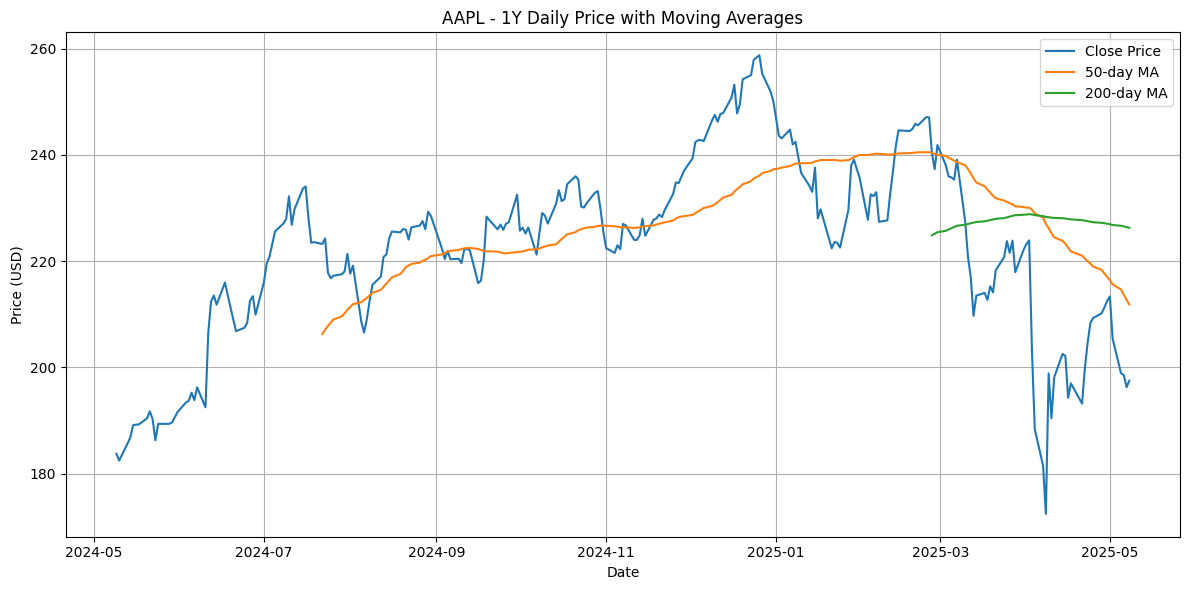

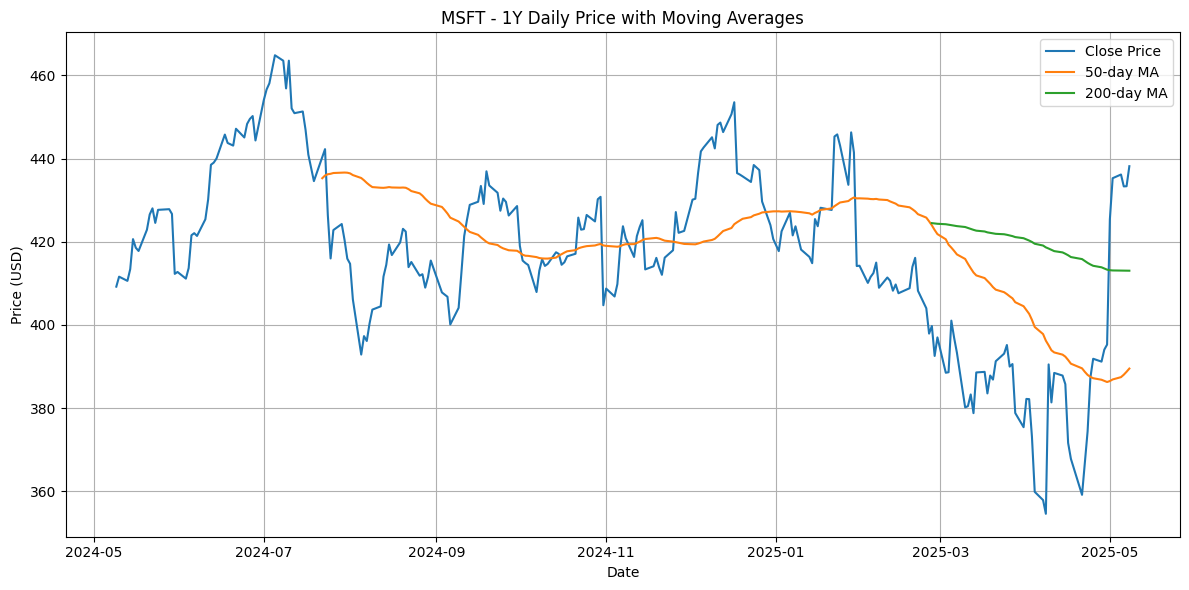

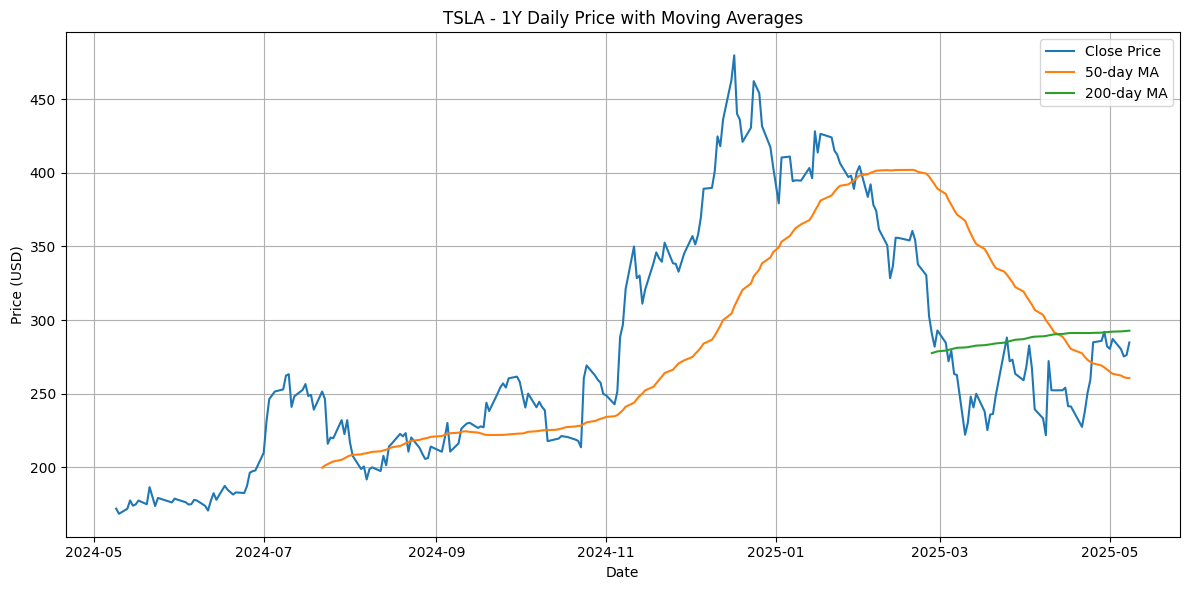

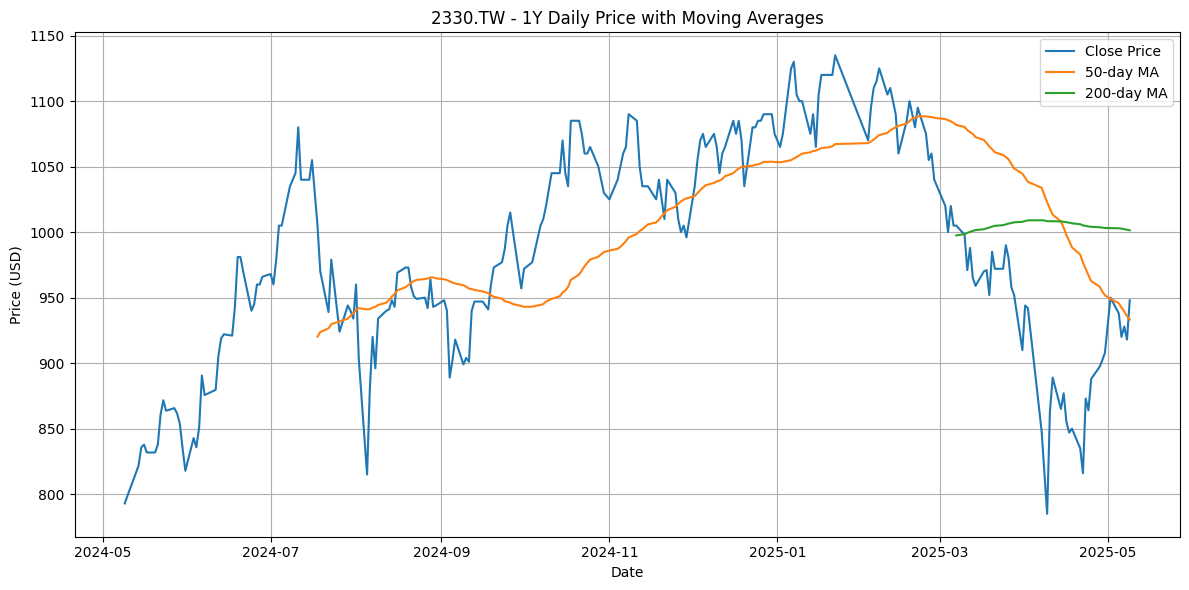

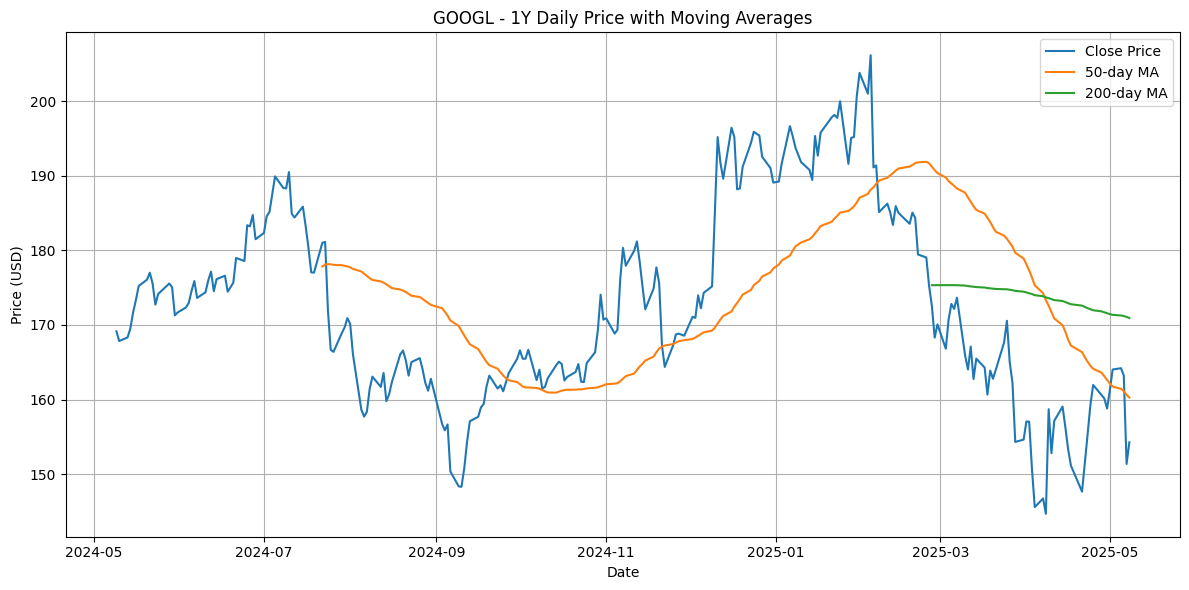

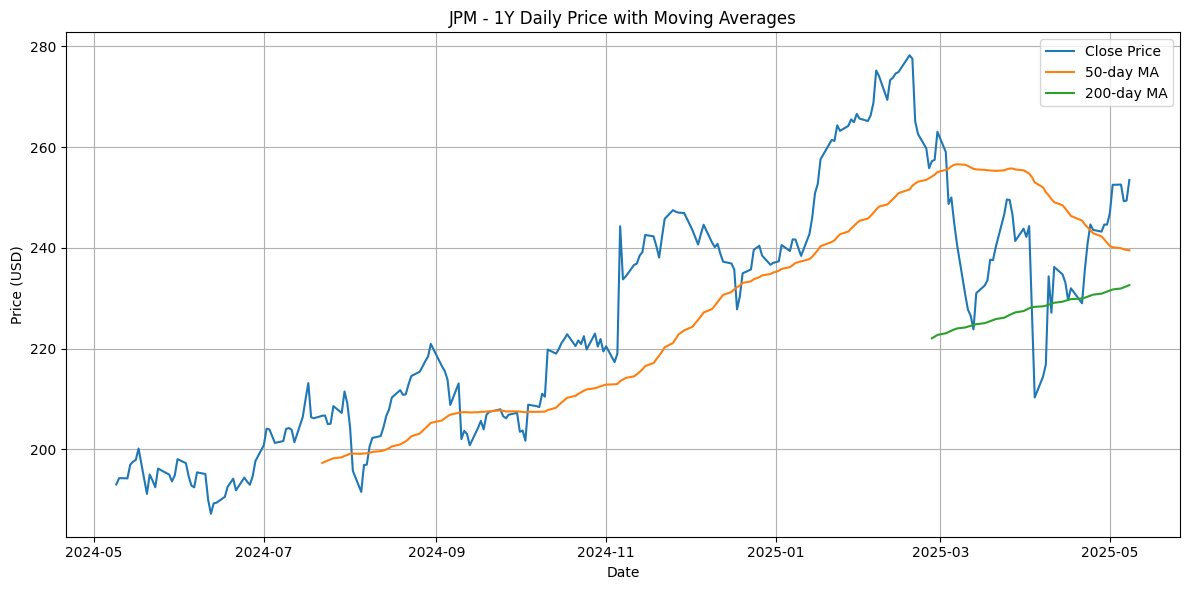

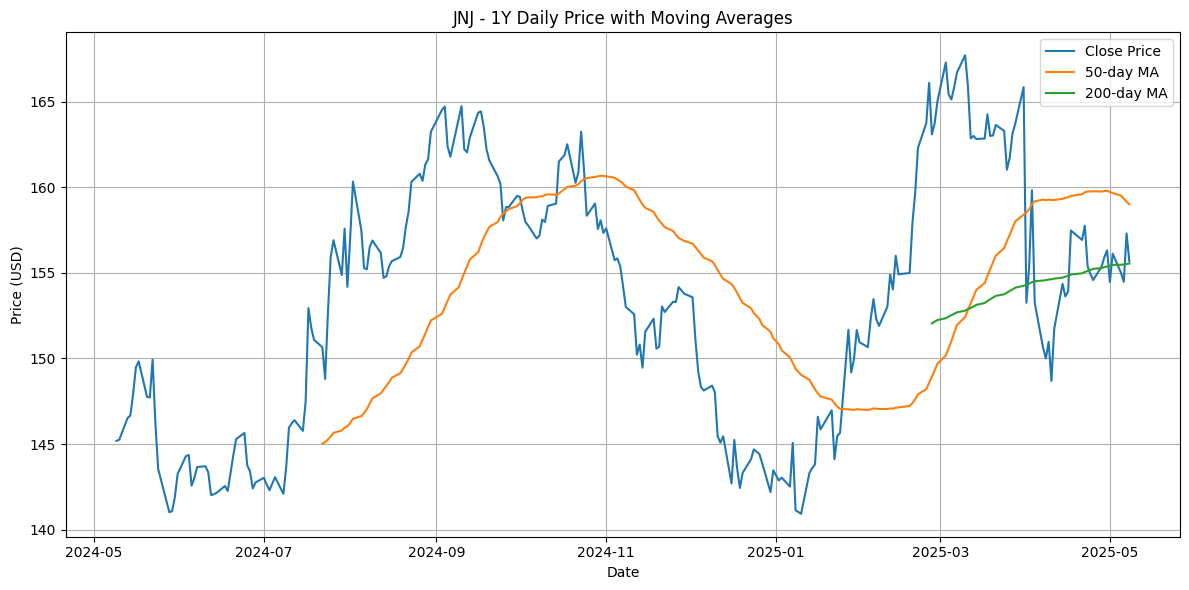

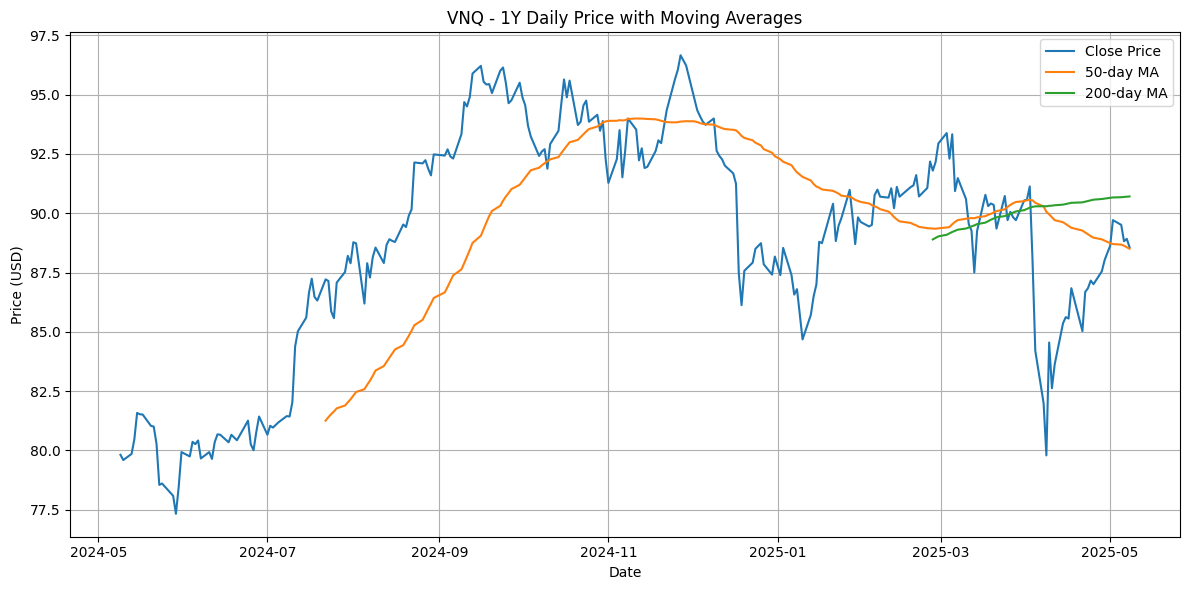

In [13]:
# Plot price + moving averages for all tickers
for ticker in df['Ticker']:
    if ticker not in price_data:
        print(f"Skipping {ticker} due to missing data.")
        continue
    
    data = price_data[ticker]['1y_daily']
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['MA50'], label='50-day MA')
    plt.plot(data['MA200'], label='200-day MA')
    plt.title(f"{ticker} - 1Y Daily Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

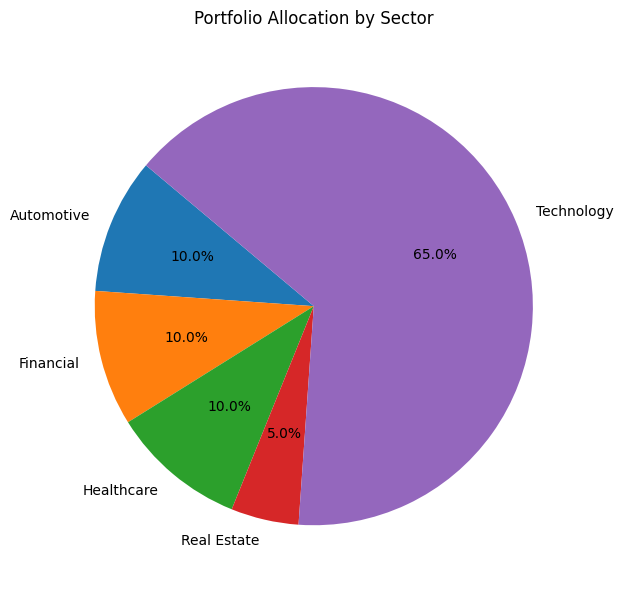

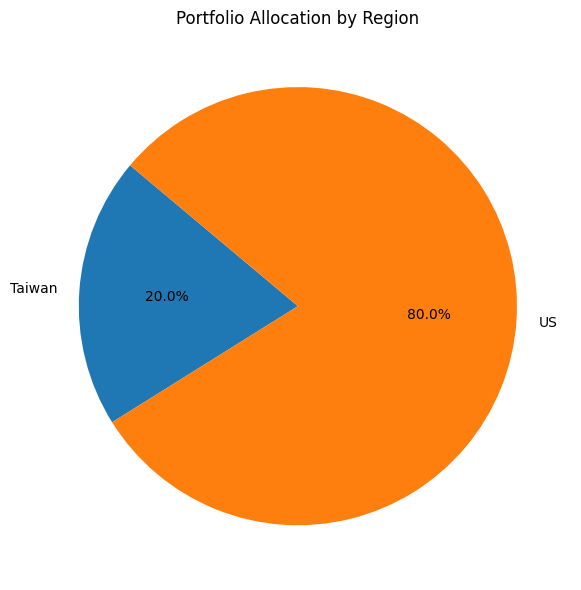

In [14]:
# name this file: sector_and_region_allocation_charts.ipynb
# Copy and paste this into a Jupyter Notebook
# Run each cell sequentially.


# Cell 9: Sector Allocation Pie Chart
plt.figure(figsize=(8, 6))
sector_data = df.groupby('Sector')['Allocation (%)'].sum()
sector_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Sector")
plt.ylabel("")  # Hides y-label
plt.tight_layout()
plt.show()

# Cell 10: Region Allocation Pie Chart
plt.figure(figsize=(8, 6))
region_data = df.groupby('Region')['Allocation (%)'].sum()
region_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Region")
plt.ylabel("")  # Hides y-label
plt.tight_layout()
plt.show()


In [15]:
# Copy and paste this into Jupyter Notebook entitled: financial_visual_analysis.ipynb
# Run each cell sequentially.
# When you reach the plotting section, you’ll see a chart for 
# your first entered ticker.

# Cell 11: Build Return DataFrame for Correlation and Risk Analysis
returns_df = pd.DataFrame()

for ticker in df['Ticker']:
    try:
        daily_prices = price_data[ticker]['1y_daily']['Close']
        returns = daily_prices.pct_change().dropna()
        returns_df[ticker] = returns
    except KeyError:
        print(f"Missing data for {ticker}")



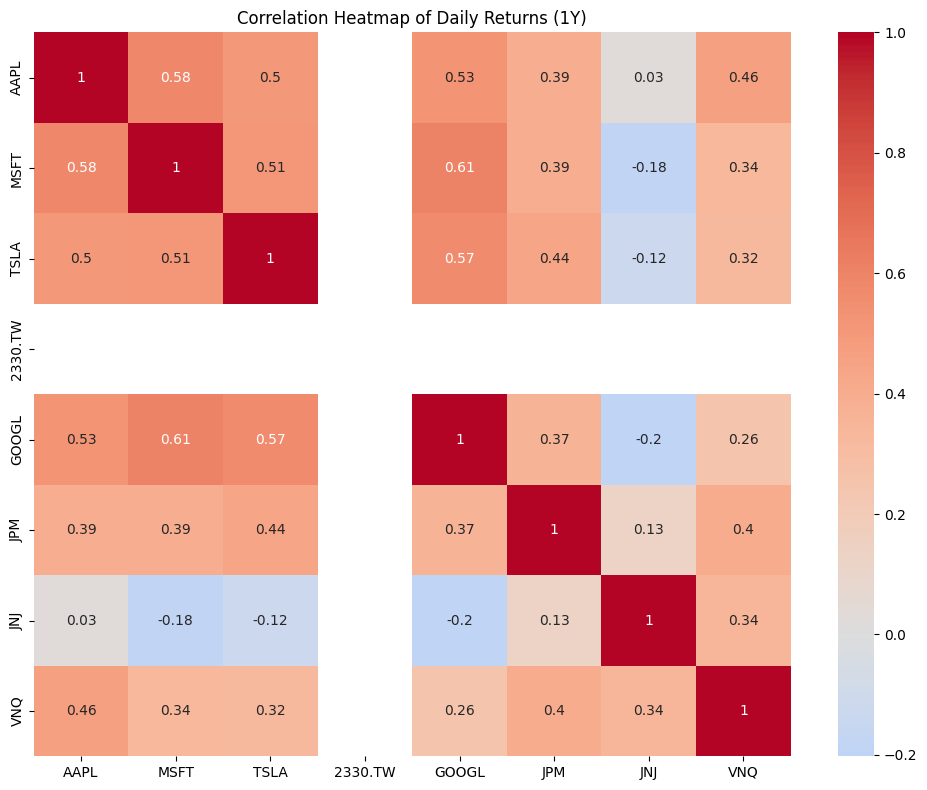

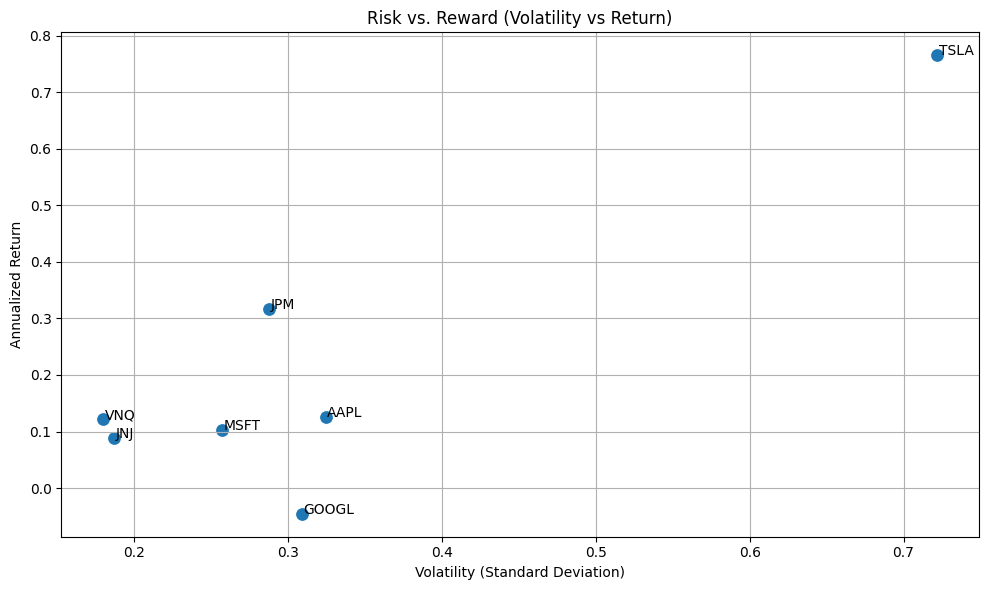

In [16]:
# Cell 12: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = returns_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Daily Returns (1Y)")
plt.tight_layout()
plt.show()

# Cell 13: Risk vs. Reward Scatter Plot
annualized_return = returns_df.mean() * 252  # 252 trading days
annualized_volatility = returns_df.std() * (252 ** 0.5)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=annualized_volatility, y=annualized_return, s=100)

for ticker in returns_df.columns:
    plt.text(annualized_volatility[ticker] + 0.001, annualized_return[ticker], ticker)

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Annualized Return")
plt.title("Risk vs. Reward (Volatility vs Return)")
plt.grid(True)
plt.tight_layout()
plt.show()